# Представление невыпуклого полинома разностью выпуклых

Существует полином $y=xz$, который не является ни выпуклым ни вогнутым. Для расчета задач со смесями его необходимо представить суммой выпклого и невыпуклого полинома. Тогда его значение можно будет рассчитать через двойственно-прямую задачу линейного программирования, которая полностью определяется своими ограничениями и независит от конкретного функционала, что позволить встроить эти значения в качестве ограничений для более сложных задач.

Поскольку работы ведутся для задачи со смесями у нас появляются дополнительные ограничения: $0 \le x,z \le 1$, $0< x + z, <=1$.

## Проверка

Существует выпуклая квадратичная форма $y = x^2 + xz + z^2$. Проверим на выпуклость через критерий сильвестра

In [1]:
from sympy import init_session
init_session()

IPython console for SymPy 1.6.2 (Python 3.8.5-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.6.2/



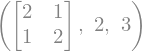

In [2]:
y = x**2 + x*z + z**2
h = hessian(y,[x,z])
h,h[0,0],det(h)

Отлично, форма положительно определена. Теперь проверим близкую к ней квадратичную форму, такую, чтобы их разность давала искомую функцию: $y = x^2 + z^2$

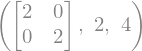

In [3]:
y = x**2 + z**2
h = hessian(y,[x,z])
h,h[0,0],det(h)

## Построение

In [4]:
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray

import numpy as np

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


Для начала модифицируем нашу функцию рассчета из прошлой [работы](lp_piecewise_functions.ipynb)

In [20]:
def plppd2dcc(xs,zs,ys_pos,ys_neg,x_0,z_0, debug=False):
    x,z,y_pos,y_neg = xs,zs,ys_pos,ys_neg
    dim_p = len(x)
    rhs_p = np.array([x_0,z_0, 1], dtype=np.double)
    dim_d = len(rhs_p) 
    
    s_pos = CyClpSimplex()
    u_pos = s_pos.addVariable('u', dim_p)
    l_pos = s_pos.addVariable('l', dim_d)

    s_neg = CyClpSimplex()
    u_neg = s_neg.addVariable('u', dim_p)
    l_neg = s_neg.addVariable('l', dim_d)


    A_p_pos = np.vstack([y_pos,
                         x,
                         z,
                         np.ones(dim_p)])
    A_p_neg = np.vstack([y_neg,
                         x,
                         z,
                         np.ones(dim_p)])

    A_p_pos = np.matrix(A_p_pos)
    A_p_neg = np.matrix(A_p_neg)

    b_p = CyLPArray(np.hstack([0,rhs_p]))
    b_d_pos = CyLPArray(y_pos)
    b_d_neg = CyLPArray(y_neg)
    
    A_d = np.hstack([x.reshape(-1, 1),
                     z.reshape(-1, 1),
                     np.ones(len(x)).reshape(-1, 1)])
    A_d = np.matrix(A_d)
    b_d = CyLPArray(y)
    
    A_d1 = np.matrix(np.vstack([-rhs_p,np.zeros((3,3))]))
    
    s_pos += A_p_pos*u_pos + A_d1*l_pos  == b_p
    s_neg += A_p_neg*u_neg + A_d1*l_neg  == b_p

    for i in range(dim_p):
        s_pos += u_pos[i] >= 0
        s_neg += u_neg[i] >= 0

    s_pos += A_d*l_pos <= b_d_pos
    s_neg += A_d*l_neg >= b_d_neg
    
    s_pos.objective = u_pos[0]
    s_neg.objective = u_neg[0]
    
    s_pos.primal()
    s_neg.primal()
    
    cond_pos = s_pos.primalVariableSolution['u']
    yr_pos = np.dot(cond_pos, y_pos)

    cond_neg = s_neg.primalVariableSolution['u']
    yr_neg = np.dot(cond_neg, y_neg)
    if not debug:
        return yr_pos + yr_neg 
    else:
        return yr_pos + yr_neg, s_pos.getStatusCode(),s_neg.getStatusCode()

In [6]:
xa,xb = 0,1
za,zb = 0,1
grid_step = 0.1
x = np.arange(xa, xb, grid_step, dtype=np.double)
z = np.arange(za, zb, grid_step, dtype=np.double)
x,z = np.meshgrid(x, z)
y_cvx = x**2 + x * z + z**2
y_ccv = - x**2 - z**2

x = x.flatten()
z = z.flatten()
y_cvx = y_cvx.flatten()
y_ccv = y_ccv.flatten()

mask = x+z <= 1

x = x[mask]
z = z[mask]
y_cvx = y_cvx[mask]
y_ccv = y_ccv[mask]
plppd2dcc(x,z,y_cvx,y_ccv,0.5,0.5)

На простом значении работает, теперь попробуем на всем множестве точек.

In [7]:
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/dvapan/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['log', 'binomial', 'sinc', 'lcm', 'sin', 'exp', 'Polygon', 'invert', 'fft', 'det', 'Circle', 'poly', 'f', 'transpose', 'sinh', 'trunc', 'roots', 're', 'ifft', 'prod', 'seterr', 'var', 'reshape', 'product', 'plot', 'array', 'Number', 'ones', 'Line2D', 'zeros', 'trace', 'cos', 'maximum', 'beta', 'source', 'partition', 'tan', 'cosh', 'eye', 'take', 'gcd', 'test', 'power', 'vectorize', 'diff', 'minimum', 'sqrt', 'cbrt', 'pi', 'plotting', 'diag', 'mod', 'add', 'interactive', 'tanh', 'floor', 'flatten', 'multinomial', 'conjugate', 'sign', 'gamma', 'solve', 'nan']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [9]:
test_step = grid_step/2.
xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)

mask = xs+zs <= 1
xs = xs[mask]
zs = zs[mask]
ys = np.empty(len(xs))

ys = []
lst = list(zip(xs,zs))
for x0,z0 in tqdm(lst):
    ys.append(plppd2dcc(x,z,y_cvx,y_ccv,x0,z0))
ys = np.array(ys)

xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)
yy = np.empty_like(xs)
mask = xs+zs <= 1

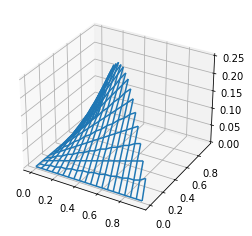

In [10]:
yy[xs+zs > 1] = None
yy[mask] = ys
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(xs, zs, yy)

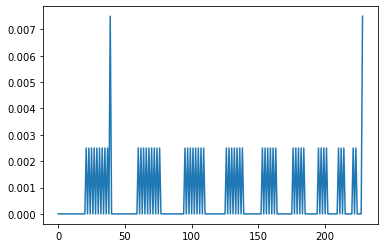

In [11]:
y_t = xs*zs
y_t[xs+zs > 1] = None
d = abs(y_t - yy)
d = d[mask]
plt.plot(d)

In [12]:
print(*list(zip(xs[mask][d>0.0007],zs[mask][d>0.0007])), sep='\n')

(0.05, 0.05)
(0.15000000000000002, 0.05)
(0.25, 0.05)
(0.35000000000000003, 0.05)
(0.45, 0.05)
(0.55, 0.05)
(0.65, 0.05)
(0.75, 0.05)
(0.8500000000000001, 0.05)
(0.9500000000000001, 0.05)
(0.05, 0.15000000000000002)
(0.15000000000000002, 0.15000000000000002)
(0.25, 0.15000000000000002)
(0.35000000000000003, 0.15000000000000002)
(0.45, 0.15000000000000002)
(0.55, 0.15000000000000002)
(0.65, 0.15000000000000002)
(0.75, 0.15000000000000002)
(0.8500000000000001, 0.15000000000000002)
(0.05, 0.25)
(0.15000000000000002, 0.25)
(0.25, 0.25)
(0.35000000000000003, 0.25)
(0.45, 0.25)
(0.55, 0.25)
(0.65, 0.25)
(0.75, 0.25)
(0.05, 0.35000000000000003)
(0.15000000000000002, 0.35000000000000003)
(0.25, 0.35000000000000003)
(0.35000000000000003, 0.35000000000000003)
(0.45, 0.35000000000000003)
(0.55, 0.35000000000000003)
(0.65, 0.35000000000000003)
(0.05, 0.45)
(0.15000000000000002, 0.45)
(0.25, 0.45)
(0.35000000000000003, 0.45)
(0.45, 0.45)
(0.55, 0.45)
(0.05, 0.55)
(0.15000000000000002, 0.55)
(0.25, 

In [13]:
plppd2dcc(x,z,y_cvx,y_ccv,0.975,0.025), 0.975*0.025, abs(plppd2dcc(x,z,y_cvx,y_ccv,0.975,0.025)- 0.975*0.025)

In [14]:
test_step = grid_step/10.
xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)

mask = xs+zs <= 1
xs = xs[mask]
zs = zs[mask]
ys = np.empty(len(xs))

ys = []
lst = list(zip(xs,zs))
for x0,z0 in tqdm(lst):
    ys.append(plppd2dcc(x,z,y_cvx,y_ccv,x0,z0))
ys = np.array(ys)

xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)
yy = np.empty_like(xs)
mask = xs+zs <= 1

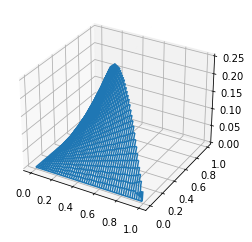

In [15]:
yy[xs+zs > 1] = None
yy[mask] = ys
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(xs, zs, yy)

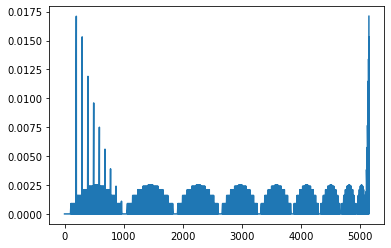

In [16]:
y_t = xs*zs
y_t[xs+zs > 1] = None
d = abs(y_t - yy)
d = d[mask]
plt.plot(d)

In [17]:
print(*list(zip(xs[mask][d>0.005],zs[mask][d>0.005])), sep='\n')

(0.93, 0.01)
(0.9400000000000001, 0.01)
(0.9500000000000001, 0.01)
(0.96, 0.01)
(0.97, 0.01)
(0.98, 0.01)
(0.99, 0.01)
(0.93, 0.02)
(0.9400000000000001, 0.02)
(0.9500000000000001, 0.02)
(0.96, 0.02)
(0.97, 0.02)
(0.98, 0.02)
(0.93, 0.03)
(0.9400000000000001, 0.03)
(0.9500000000000001, 0.03)
(0.96, 0.03)
(0.97, 0.03)
(0.9400000000000001, 0.04)
(0.9500000000000001, 0.04)
(0.96, 0.04)
(0.9400000000000001, 0.05)
(0.9500000000000001, 0.05)
(0.9400000000000001, 0.06)
(0.01, 0.93)
(0.02, 0.93)
(0.03, 0.93)
(0.01, 0.9400000000000001)
(0.02, 0.9400000000000001)
(0.03, 0.9400000000000001)
(0.04, 0.9400000000000001)
(0.05, 0.9400000000000001)
(0.06, 0.9400000000000001)
(0.01, 0.9500000000000001)
(0.02, 0.9500000000000001)
(0.03, 0.9500000000000001)
(0.04, 0.9500000000000001)
(0.05, 0.9500000000000001)
(0.01, 0.96)
(0.02, 0.96)
(0.03, 0.96)
(0.04, 0.96)
(0.01, 0.97)
(0.02, 0.97)
(0.03, 0.97)
(0.01, 0.98)
(0.02, 0.98)
(0.01, 0.99)


In [18]:
plppd2dcc(x,z,y_cvx,y_ccv,0.99,0.01), 0.99*0.01, abs(plppd2dcc(x,z,y_cvx,y_ccv,0.99,0.01)- 0.99*0.01)

Еще одна особенность этих точек: в них не решаются задачи ЛП.

In [22]:
plppd2dcc(x,z,y_cvx,y_ccv,0.99,0.01, debug=True)

Проблемы происходят на границах. А что если увеличить количество точек, на которых проведен рассчет?

In [25]:
xa,xb = 0,1
za,zb = 0,1
grid_step = 0.1
xa_ext = xa - grid_step
xb_ext = xb + grid_step
za_ext = za - grid_step
zb_ext = zb + grid_step


x = np.arange(xa_ext, xb_ext, grid_step, dtype=np.double)
z = np.arange(za_ext, zb_ext, grid_step, dtype=np.double)
x,z = np.meshgrid(x, z)
y_cvx = x**2 + x * z + z**2
y_ccv = - x**2 - z**2

x = x.flatten()
z = z.flatten()
y_cvx = y_cvx.flatten()
y_ccv = y_ccv.flatten()

mask = x+z <= 1

x = x[mask]
z = z[mask]
y_cvx = y_cvx[mask]
y_ccv = y_ccv[mask]
plppd2dcc(x,z,y_cvx,y_ccv,0.99,0.01, debug=True)

Видно, что теперь задача решается. Проверим на большом количестве точек.

In [26]:
test_step = grid_step/2.
xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)

mask = xs+zs <= 1
xs = xs[mask]
zs = zs[mask]
ys = np.empty(len(xs))

ys = []
lst = list(zip(xs,zs))
for x0,z0 in tqdm(lst):
    ys.append(plppd2dcc(x,z,y_cvx,y_ccv,x0,z0))
ys = np.array(ys)

xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)
yy = np.empty_like(xs)
mask = xs+zs <= 1

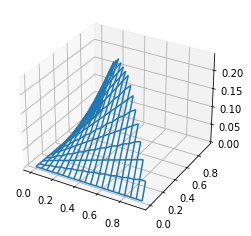

In [27]:
yy[xs+zs > 1] = None
yy[mask] = ys
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(xs, zs, yy)

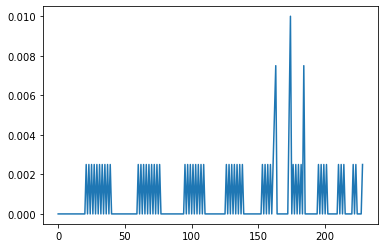

In [28]:
y_t = xs*zs
y_t[xs+zs > 1] = None
d = abs(y_t - yy)
d = d[mask]
plt.plot(d)

In [31]:
print(*list(zip(xs[mask][d>0.005],zs[mask][d>0.005])), sep='\n')

(0.55, 0.45)
(0.5, 0.5)
(0.45, 0.55)


In [33]:
plppd2dcc(x,z,y_cvx,y_ccv,0.5,0.5, debug=True), 0.5*0.5

Странное расхождение. Да еще и такое большое. Видимо стоит добавит точек и со стороны диагональной границы

In [35]:
xa,xb = 0,1
za,zb = 0,1
grid_step = 0.1
xa_ext = xa - grid_step
xb_ext = xb + grid_step
za_ext = za - grid_step
zb_ext = zb + grid_step


x = np.arange(xa_ext, xb_ext, grid_step, dtype=np.double)
z = np.arange(za_ext, zb_ext, grid_step, dtype=np.double)
x,z = np.meshgrid(x, z)
y_cvx = x**2 + x * z + z**2
y_ccv = - x**2 - z**2

x = x.flatten()
z = z.flatten()
y_cvx = y_cvx.flatten()
y_ccv = y_ccv.flatten()

mask = x+z <= 1+grid_step

x = x[mask]
z = z[mask]
y_cvx = y_cvx[mask]
y_ccv = y_ccv[mask]
plppd2dcc(x,z,y_cvx,y_ccv,0.99,0.01, debug=True), plppd2dcc(x,z,y_cvx,y_ccv,0.5,0.5, debug=True)

In [36]:
test_step = grid_step/2.
xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)

mask = xs+zs <= 1
xs = xs[mask]
zs = zs[mask]
ys = np.empty(len(xs))

ys = []
lst = list(zip(xs,zs))
for x0,z0 in tqdm(lst):
    ys.append(plppd2dcc(x,z,y_cvx,y_ccv,x0,z0))
ys = np.array(ys)

xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)
yy = np.empty_like(xs)
mask = xs+zs <= 1

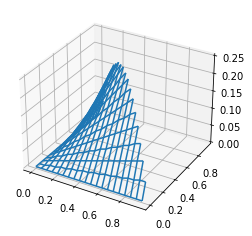

In [37]:
yy[xs+zs > 1] = None
yy[mask] = ys
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(xs, zs, yy)

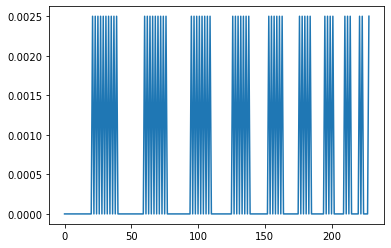

In [39]:
y_t = xs*zs
y_t[xs+zs > 1] = None
d = abs(y_t - yy)
d = d[mask]
plt.plot(d)

Получаем следующее максимальное отклонение от значения, при заданном шаге сетки:

In [45]:
print(max(d),test_step)

0.002500000000290846 0.05


Проверим теперь на более мелкой сетке:

In [46]:
test_step = grid_step/10.
xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)

mask = xs+zs <= 1
xs = xs[mask]
zs = zs[mask]
ys = np.empty(len(xs))

ys = []
lst = list(zip(xs,zs))
for x0,z0 in tqdm(lst):
    ys.append(plppd2dcc(x,z,y_cvx,y_ccv,x0,z0))
ys = np.array(ys)

xs = np.arange(xa, xb, test_step, dtype=np.double)
zs = np.arange(za, zb, test_step, dtype=np.double)
xs,zs = np.meshgrid(xs, zs)
yy = np.empty_like(xs)
mask = xs+zs <= 1

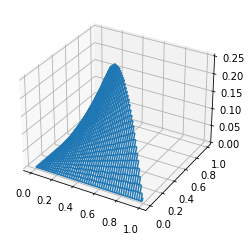

In [47]:
yy[xs+zs > 1] = None
yy[mask] = ys
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(xs, zs, yy)

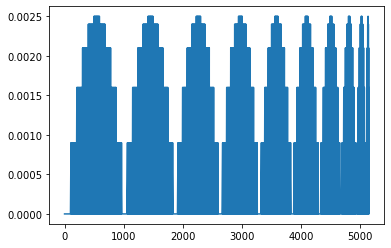

In [48]:
y_t = xs*zs
y_t[xs+zs > 1] = None
d = abs(y_t - yy)
d = d[mask]
plt.plot(d)

## Вывод

При разбиении функции $y=xz$ на разнось выпуклых функций получаем весьма приемлемую точность приближения.